In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from utils import *

print(torch.cuda.is_available())
print(torch.device('cuda'))
print(torch.cuda.device_count())
print(torch.version.cuda)

True
cuda
3
11.0


/root/miniconda3/envs/mat_inpainting/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataset 512
import opendatasets as od
import zipfile

# dataset 1024
import os
import zipfile
import gdown
from sklearn.model_selection import train_test_split

# mask
sys.path.append(os.path.abspath('/root/home/MAT_demo/'))
from datasets import mask_generator_512, mask_generator_256

# eval
from evaluation import cal_fid_pids_uids, cal_lpips, cal_psnr_ssim_l1
import contextlib

# Others
import glob
import importlib
importlib.reload(cal_fid_pids_uids)
importlib.reload(cal_lpips)
importlib.reload(cal_psnr_ssim_l1)

<module 'evaluation.cal_psnr_ssim_l1' from '../evaluation/cal_psnr_ssim_l1.py'>

### Download dataset

#### 512x512

In [8]:
od.download('https://www.kaggle.com/datasets/vincenttamml/celebamaskhq512?select=image')

!mv celebamaskhq512/image/* ../Data/CelebA-HQ/CelebA-HQ-img
!cd .. && for file in $(cat Data/CelebA-HQ/val_img_names.txt); do mv "Data/CelebA-HQ/CelebA-HQ-img/$file" Data/CelebA-HQ/CelebA-HQ-val_img; done
!rm -r celebamaskhq512

In [12]:
!ls ../Data/CelebA-HQ/CelebA-HQ-img | wc -l

27007


In [13]:
!ls ../Data/CelebA-HQ/CelebA-HQ-val_img | wc -l

2993


#### 1024x1024

In [18]:
## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive 
# Root directory for the dataset
data_root = '/root/MAT/Data'
# Path to folder with the dataset
dataset_folder = f'{data_root}/CelebA-HQ'
# URL for the CelebA dataset
url = 'https://drive.google.com/u/0/uc?id=1jlQ8umhpJo8lVgC9q4_1q_t_Frv1kZ3f&export=download&confirm=1'
# Path to download the dataset to
download_path = f'{dataset_folder}/image.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
if not os.path.exists(dataset_folder):
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

Downloading...
From: https://drive.google.com/u/0/uc?id=1jlQ8umhpJo8lVgC9q4_1q_t_Frv1kZ3f&export=download&confirm=1
To: /root/MAT/Data/CelebA-HQ/image.zip
  4%|▍         | 79.7M/2.05G [00:09<03:34, 9.16MB/s]

100%|██████████| 2.05G/2.05G [04:04<00:00, 8.35MB/s]


In [12]:
!ls /root/MAT/Data/CelebA-HQ/CelebA-HQ-all | wc -l

30000


In [20]:
img_idx = train_test_split(np.arange(30000), test_size=2993)[1]
img_idx.sort()
with open('Data/CelebA-HQ/val_img_names.txt', 'w') as f:
    for idx in img_idx:
        f.write(str(idx) + '.jpg\n')

In [21]:
!mkdir Data/CelebA-HQ/CelebA-HQ-img/
!mkdir Data/CelebA-HQ/CelebA-HQ-val_img/
!cp Data/CelebA-HQ/CelebA-HQ-all/* Data/CelebA-HQ/CelebA-HQ-img
!for file in $(cat Data/CelebA-HQ/val_img_names.txt); do mv "Data/CelebA-HQ/CelebA-HQ-img/$file" Data/CelebA-HQ/CelebA-HQ-val_img; done

In [10]:
!ls /root/MAT/Data/CelebA-HQ/CelebA-HQ-img | wc -l

27007


In [11]:
!ls /root/MAT/Data/CelebA-HQ/CelebA-HQ-val_img | wc -l

2993


### Training (input 1024x1024)

**Explore options:**
- cfg
    - Base config: 'auto' (default), 'stylegan2', 'paper256', 'paper512', 'paper1024', 'cifar'
    - 'auto', 'stylegan2', 'places256', 'places512', 'celeba512'
    - 'auto', 'stylegan2', 'paper256', 'paper512', 'inp512', 'paper1024', 'cifar', 'places256', 'places512', 'celeba512'
- resume: Load previous network: 'noresume' (default), 'ffhq256', 'ffhq512', 'ffhq1024', 'celebahq256', 'lsundog256', <file>, <url>

### Eval

#### 00033-1024_LargeMask

In [62]:
%%time
!python generate_image_having_stg1.py \
    --network saved_model/00033-CelebA-HQ-img-mirror-celeba512-mat-lr0.001-TwoStageLoss-pr0.1-nopl-kimg200-batch12-tc0.5-sm0.5-ema10-noaug-resumecustom/network-snapshot-000200.pkl \
    --dpath Data/CelebA-HQ-1024/CelebA-HQ-val_img-512 \
    --maskdir Results/Ours/00033-1024-masks \
    --outdir Results/Ours/00033-1024_SmallMask \
    --out1dir Results/Ours/00033-1024_SmallMask_stg1 \
    --large-mask False

/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")
Loading data from: Data/CelebA-HQ-1024/CelebA-HQ-val_img-512
Loading networks from: saved_model/00033-CelebA-HQ-img-mirror-celeba512-mat-lr0.001-TwoStageLoss-pr0.1-nopl-kimg200-batch12-tc0.5-sm0.5-ema10-noaug-resumecustom/network-snapshot-000200.pkl
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
>>>>> 1.002338790511193%
>>>>> 2.004677581022386%
>>>>> 3.0070163715335783%
>>>>> 4.009355162044772%
>>>>> 5.011693952555964%
>>>>> 6.0140327430671565%
>>>>> 7.01637153357835%
>>>>> 8.018710324089543%
>>>>> 9.021049114600736%
>>>>> 10.023387905111928%
>>>>> 11.02572669562312%
>>>>> 12.028065486134313%
>>>>> 13.03040427664

In [32]:
dpath = 'Data/CelebA-HQ-1024/CelebA-HQ-val_img-512/'
mpath = 'Results/Ours/00033-1024-masks/'
outdir = 'Results/Ours/00033-1024_SmallMask/'
out1dir = 'Results/Ours/00033-1024_SmallMask_stg1/'

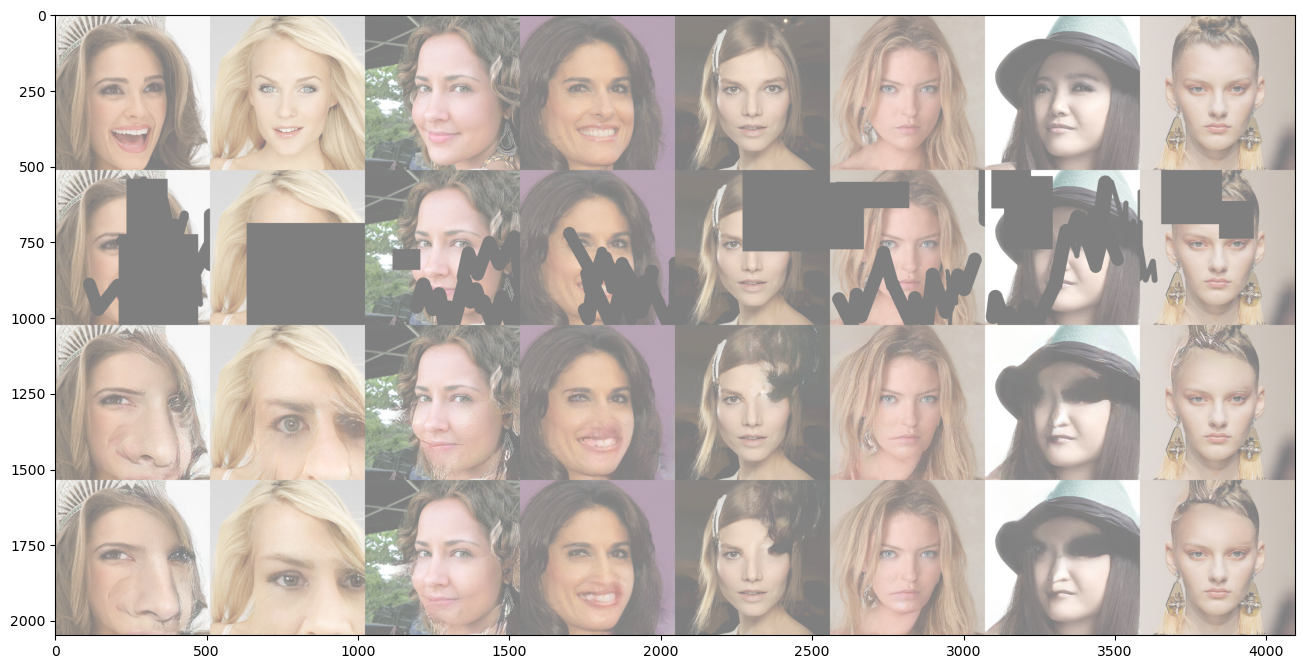

In [16]:
full_imgs = []

for i in range(8):
    full_imgs.append(mpimg.imread(dpath + str(i) + '.jpg') / 255)
for i in range(8):
    img = mpimg.imread(dpath + str(i) + '.jpg') / 255
    mask = mpimg.imread(mpath + str(i) + '.png')[..., :-1]
    full_imgs.append(img * mask)
for i in range(8):
    full_imgs.append(mpimg.imread(out1dir + str(i) + '.png'))
for i in range(8):
    full_imgs.append(mpimg.imread(outdir + str(i) + '.png'))

plot_images(np.array(full_imgs), 'rectangle', (4, 8))

In [24]:
importlib.reload(cal_fid_pids_uids)

<module 'evaluation.cal_fid_pids_uids' from '/root/MAT/evaluation/cal_fid_pids_uids.py'>

In [25]:
fid, pids, uids = cal_fid_pids_uids.calculate_metrics(outdir, dpath)
print('fid:', fid)
print('pids:', pids)
print('uids:', uids)

length: 2993


  0%|          | 0/2993 [00:00<?, ?it/s]

SVM fitting ...
fid: 7.204614476512072
pids: 0.056130972268626796
uids: 0.15536251252923483


In [33]:
lpips = cal_lpips.calculate_metrics(outdir, dpath)
psnr, ssim, l1 = cal_psnr_ssim_l1.calculate_metrics(outdir, dpath)

print('lpips:', lpips)
print('psnr:', psnr)
print('ssim:', ssim)
print('l1:', l1)

length: 2993
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/2993 [00:00<?, ?it/s]

length: 2993


  0%|          | 0/2993 [00:00<?, ?it/s]

pids: 0.056130972268626796
uids: 0.15536251252923483
lpips: 0.10412300956668186
psnr: 26.10195887965294
ssim: 0.8962156532374149
l1: 0.023686337303725002


#### Re-test-MAT_LargeMask

In [24]:
%%time
!CUDA_VISIBLE_DEVICES=2 python generate_image_having_stg1.py \
    --network pretrained/CelebA-HQ_512.pkl \
    --dpath Data/CelebA-HQ/CelebA-HQ-val_img \
    --mpath Masks_val/masks_val_512_eval \
    --outdir Results/Paper/Re-test-MAT_LargeMask \
    --out1dir Results/Paper/Re-test-MAT_LargeMask_stg1 \
    --large-mask True

/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")
Loading data from: Data/CelebA-HQ/CelebA-HQ-val_img
Loading mask from: Masks_val/masks_val_512_eval
Loading networks from: pretrained/CelebA-HQ_512.pkl


Prcessing: 1000.png
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
output of D: stg1 - tensor(-0.7596, device='cuda:0') final - tensor(-2.7442, device='cuda:0')
Prcessing: 10017.png
output of D: stg1 - tensor(-0.7284, device='cuda:0') final - tensor(-1.1102, device='cuda:0')
Prcessing: 10037.png
output of D: stg1 - tensor(-0.8972, device='cuda:0') final - tensor(-1.5870, device='cuda:0')
Prcessing: 10045.png
output of D: stg1 - tensor(-0.7781, device='cuda:0') final - tensor(-1.3923, device='cuda:0')
Prcessing: 10058.png
output of D: stg1 - tensor(-0.7669, device='cuda:0') final - tensor(-1.6343, device='cuda:0')
Prcessing: 10059.png
output of D: stg1 - tensor(-0.6770, device='cuda:0') final - tensor(-1.4490, device='cuda:0')
Prcessing: 10063.png
output of D: stg1 - tensor(-0.8862, device='cuda:0') final - tensor(-1.8742, device='cuda:0')
Prcessing: 1007.png
output of D: stg1 - tensor(-0.9363, device='cuda:0') final - tensor(-

In [25]:
dpath = 'Data/CelebA-HQ/CelebA-HQ-val_img/'
mpath = 'Masks_val/masks_val_512_eval/'
RetestMAT_outdir = 'Results/Paper/Re-test-MAT_LargeMask/'
RetestMAT_outdir_stg1 = 'Results/Paper/Re-test-MAT_LargeMask_stg1'

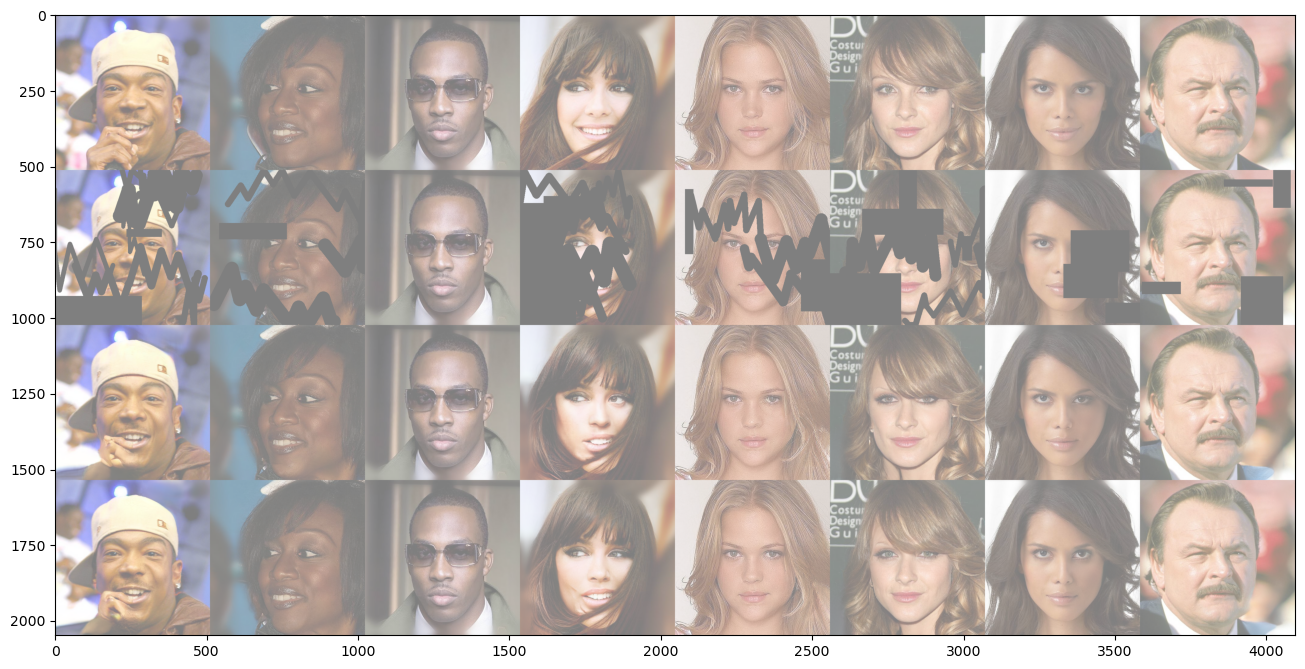

In [27]:
full_imgs = []
img_list = sorted(glob.glob(dpath + '/*.png') + glob.glob(dpath + '/*.jpg'))
img_mask = sorted(glob.glob(mpath + '/*.png') + glob.glob(mpath + '/*.jpg'))
sample_list = sorted(glob.glob(RetestMAT_outdir + '/*.png') + glob.glob(RetestMAT_outdir + '/*.jpg'))
sample_stg1_list = sorted(glob.glob(RetestMAT_outdir_stg1 + '/*.png') + glob.glob(RetestMAT_outdir_stg1 + '/*.jpg'))

for img in img_list[:8]:
    full_imgs.append(mpimg.imread(img) / 255)
for img_mask in zip(img_list[:8], img_mask):
    img = mpimg.imread(img_mask[0]) / 255
    mask = mpimg.imread(img_mask[1])[..., np.newaxis]
    full_imgs.append(img * mask)
for sample in sample_stg1_list[:8]:
    full_imgs.append(mpimg.imread(sample))
for sample in sample_list[:8]:
    full_imgs.append(mpimg.imread(sample))

plot_images(np.array(full_imgs), 'rectangle', (4, 8))

In [14]:
fid, pids, uids = cal_fid_pids_uids.calculate_metrics(RetestMAT_outdir, dpath)
print('fid:', fid)
print('pids:', pids)
print('uids:', uids)

length: 2993
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

In [15]:
lpips = cal_lpips.calculate_metrics(RetestMAT_outdir, dpath)
print('lpips:', lpips)

length: 2993
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251


In [16]:
psnr, ssim, l1 = cal_psnr_ssim_l1.calculate_metrics(RetestMAT_outdir, dpath)
print('psnr:', psnr)
print('ssim:', ssim)
print('l1:', l1)

length: 2993
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

#### MAT_LargeMask

In [ ]:
MAT_outdir = 'Results/Paper/MAT_LargeMask/'

In [5]:
fid, pids, uids = cal_fid_pids_uids.calculate_metrics(MAT_outdir, dpath)
print('fid:', fid)
print('pids:', pids)
print('uids:', uids)

length: 2993
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247


248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497


In [6]:
lpips = cal_lpips.calculate_metrics(MAT_outdir, dpath)
print('lpips:', lpips)

length: 2993
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251


In [7]:
psnr, ssim, l1 = cal_psnr_ssim_l1.calculate_metrics(MAT_outdir, dpath)
print('psnr:', psnr)
print('ssim:', ssim)
print('l1:', l1)

length: 2993
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

### Training-Eval (input 512x512)

In [ ]:
!CUDA_VISIBLE_DEVICES=1,2 nohup python -W ignore train.py \
    --outdir=saved_model \
    --gpus=2 \
    --snap=50 \
    --batch=16 \
    --kimg 3000 \
    --resume /root/MAT/saved_model/00012-CelebA-HQ-img-mirror-celeba512-mat-lr0.001-TwoStageLoss-pr0.1-nopl-kimg400-batch16-tc0.5-sm0.5-ema10-noaug-resumecustom/network-snapshot-000400.pkl \
    --metrics=fid2993_full \
    --data=/root/MAT/Data/CelebA-HQ/CelebA-HQ-img \
    --data_val=/root/MAT/Data/CelebA-HQ/CelebA-HQ-val_img \
    --dataloader=datasets.dataset_512.ImageFolderMaskDataset \
    --mirror=True \
    --cond=False \
    --cfg=celeba512 \
    --aug=noaug \
    --generator=networks.mat.Generator \
    --discriminator=networks.mat.Discriminator \
    --loss=losses.loss.TwoStageLoss \
    --pr=0.1 \
    --pl=False \
    --truncation=0.5 \
    --style_mix=0.5 \
    --ema=10 \
    --lr=0.001 \
    > stdout_bash/train_stdout4.txt \
    2> stdout_bash/train_stderr4.txt &

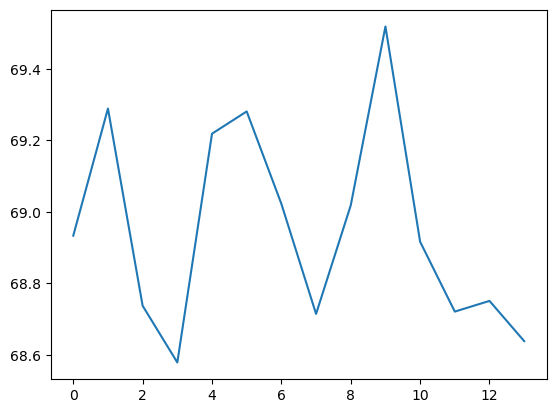

In [11]:
import pandas as pd

metrics = pd.read_json(path_or_buf='/root/MAT/saved_model/00013-CelebA-HQ-img-mirror-celeba512-mat-lr0.001-TwoStageLoss-pr0.1-nopl-kimg3000-batch16-tc0.5-sm0.5-ema10-noaug-resumecustom/metric-fid2993_full.jsonl', lines=True)
fids = []

for fid in metrics['results']:
    fids.append(fid['fid2993_full'])

plt.plot(fids)

In [14]:
!cd ../ && python generate_image_having_stg1.py \
    --network /root/MAT/saved_model/00013-CelebA-HQ-img-mirror-celeba512-mat-lr0.001-TwoStageLoss-pr0.1-nopl-kimg3000-batch16-tc0.5-sm0.5-ema10-noaug-resumecustom/network-snapshot-002600.pkl \
    --dpath Data/CelebA-HQ/CelebA-HQ-val_img \
    --mpath /root/MAT/Masks_val/masks_val_512_eval \
    --outdir /root/MAT/Results/Ours/00013-512_LargeMask \
    --out1dir /root/MAT/Results/Ours/00013-512_LargeMask_stg1

/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")
Loading data from: Data/CelebA-HQ/CelebA-HQ-val_img
Loading mask from: /root/MAT/Masks_val/masks_val_512_eval
Loading networks from: /root/MAT/saved_model/00013-CelebA-HQ-img-mirror-celeba512-mat-lr0.001-TwoStageLoss-pr0.1-nopl-kimg3000-batch16-tc0.5-sm0.5-ema10-noaug-resumecustom/network-snapshot-002600.pkl
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
>>>>> 1.002338790511193%
>>>>> 2.004677581022386%
>>>>> 3.0070163715335783%
>>>>> 4.009355162044772%
>>>>> 5.011693952555964%
>>>>> 6.0140327430671565%
>>>>> 7.01637153357835%
>>>>> 8.018710324089543%
>>>>> 9.021049114600736%
>>>>> 10.023387905111928%
>>>>> 11.02

In [25]:
dpath = '/root/MAT/Data/CelebA-HQ/CelebA-HQ-val_img'
mpath = '/root/MAT/Masks_val/masks_val_512_eval'
outdir = '/root/MAT/Results/Ours/00013-512_LargeMask'
outdir_stg1 = '/root/MAT/Results/Ours/00013-512_LargeMask_stg1'

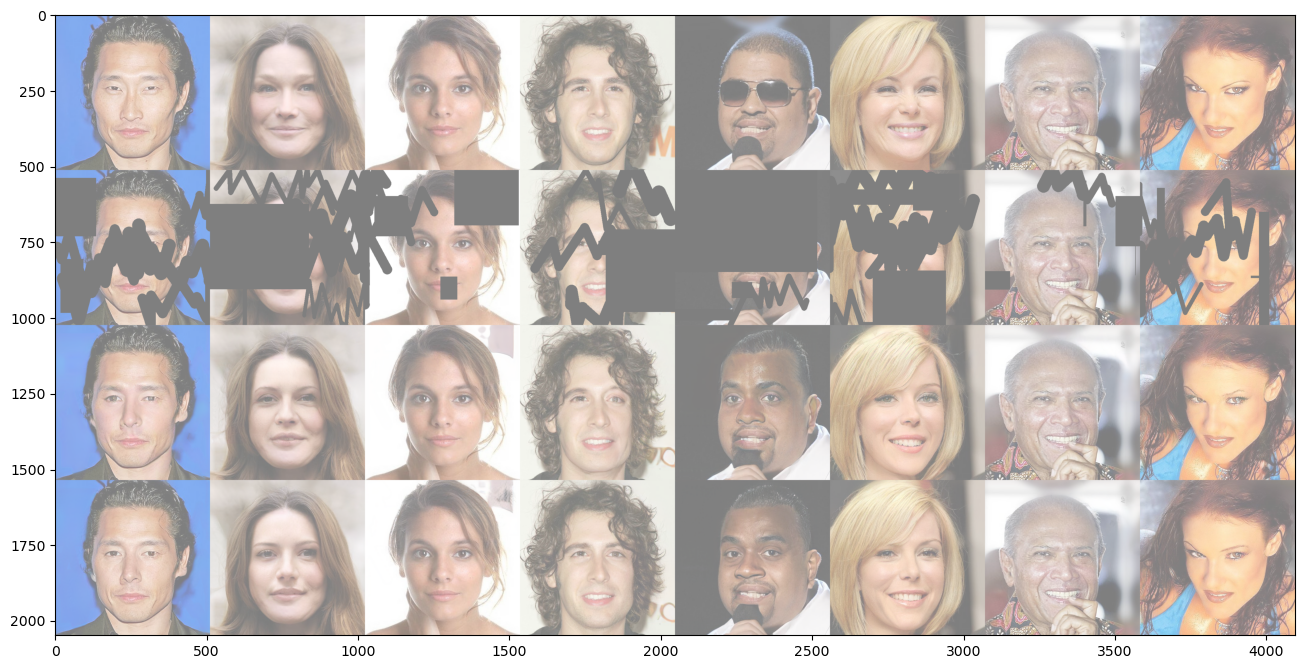

In [44]:
full_imgs = []
img_list = sorted(glob.glob(dpath + '/*.png') + glob.glob(dpath + '/*.jpg'))
mask_list = sorted(glob.glob(mpath + '/*.png') + glob.glob(mpath + '/*.jpg'))
sample_list = sorted(glob.glob(outdir + '/*.png') + glob.glob(outdir + '/*.jpg'))
sample_stg1_list = sorted(glob.glob(outdir_stg1 + '/*.png') + glob.glob(outdir_stg1 + '/*.jpg'))
random_idx_list = np.random.randint(2993, size=8)

for random_idx in random_idx_list:
    full_imgs.append(mpimg.imread(img_list[random_idx]) / 255)
for random_idx in random_idx_list:
    img = mpimg.imread(img_list[random_idx]) / 255
    mask = mpimg.imread(mask_list[random_idx])[..., np.newaxis]
    full_imgs.append(img * mask)
for random_idx in random_idx_list:
    full_imgs.append(mpimg.imread(sample_stg1_list[random_idx]))
for random_idx in random_idx_list:
    full_imgs.append(mpimg.imread(sample_list[random_idx]))

plot_images(np.array(full_imgs), 'rectangle', (4, 8))

In [27]:
fid, pids, uids = cal_fid_pids_uids.calculate_metrics(outdir, dpath)
print('fid:', fid)
print('pids:', pids)
print('uids:', uids)

lpips = cal_lpips.calculate_metrics(outdir, dpath)
print('lpips:', lpips)

psnr, ssim, l1 = cal_psnr_ssim_l1.calculate_metrics(outdir, dpath)
print('psnr:', psnr)
print('ssim:', ssim)
print('l1:', l1)

length: 2993


  0%|          | 0/2993 [00:00<?, ?it/s]

SVM fitting ...
length: 2993
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


  0%|          | 0/2993 [00:00<?, ?it/s]

length: 2993


  0%|          | 0/2993 [00:00<?, ?it/s]

fid: 5.181554809430678
pids: 0.1249582358837287
uids: 0.22736384898095552
lpips: 0.13526443669098268
psnr: 22.86274139897492
ssim: 0.8186109856256698
l1: 0.03535870744283149


In [16]:
%%time
!cd .. && python generate_image_having_stg1.py \
    --network /root/MAT/saved_model/00013-CelebA-HQ-img-mirror-celeba512-mat-lr0.001-TwoStageLoss-pr0.1-nopl-kimg3000-batch16-tc0.5-sm0.5-ema10-noaug-resumecustom/network-snapshot-002600.pkl \
    --dpath test_sets/CelebA-HQ/images2 \
    --mpath test_sets/CelebA-HQ/masks2 \
    --outdir test_sets/CelebA-HQ/samples2 \
    --out1dir test_sets/CelebA-HQ/samples2_stg1 \
    --large-mask True \
    --hole-lrange .6

/root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /root/miniconda3/envs/MAT/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")
Loading data from: test_sets/CelebA-HQ/images2
Loading mask from: test_sets/CelebA-HQ/masks2
Loading networks from: /root/MAT/saved_model/00013-CelebA-HQ-img-mirror-celeba512-mat-lr0.001-TwoStageLoss-pr0.1-nopl-kimg3000-batch16-tc0.5-sm0.5-ema10-noaug-resumecustom/network-snapshot-002600.pkl
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
----- D[stg1] = -1.3931500911712646 ~~~ D[final] = -0.28725969791412354
>>>>> 20.0%
----- D[stg1] = -1.4001073837280273 ~~~ D[final] = -0.25847911834716797
>>>>> 40.0%
----- D[stg1] = -1.4068303108215332 ~~~ D[final] = -0.2915058135986328
>>>>> 60.0%
----- D[stg1] = -1.2730455398

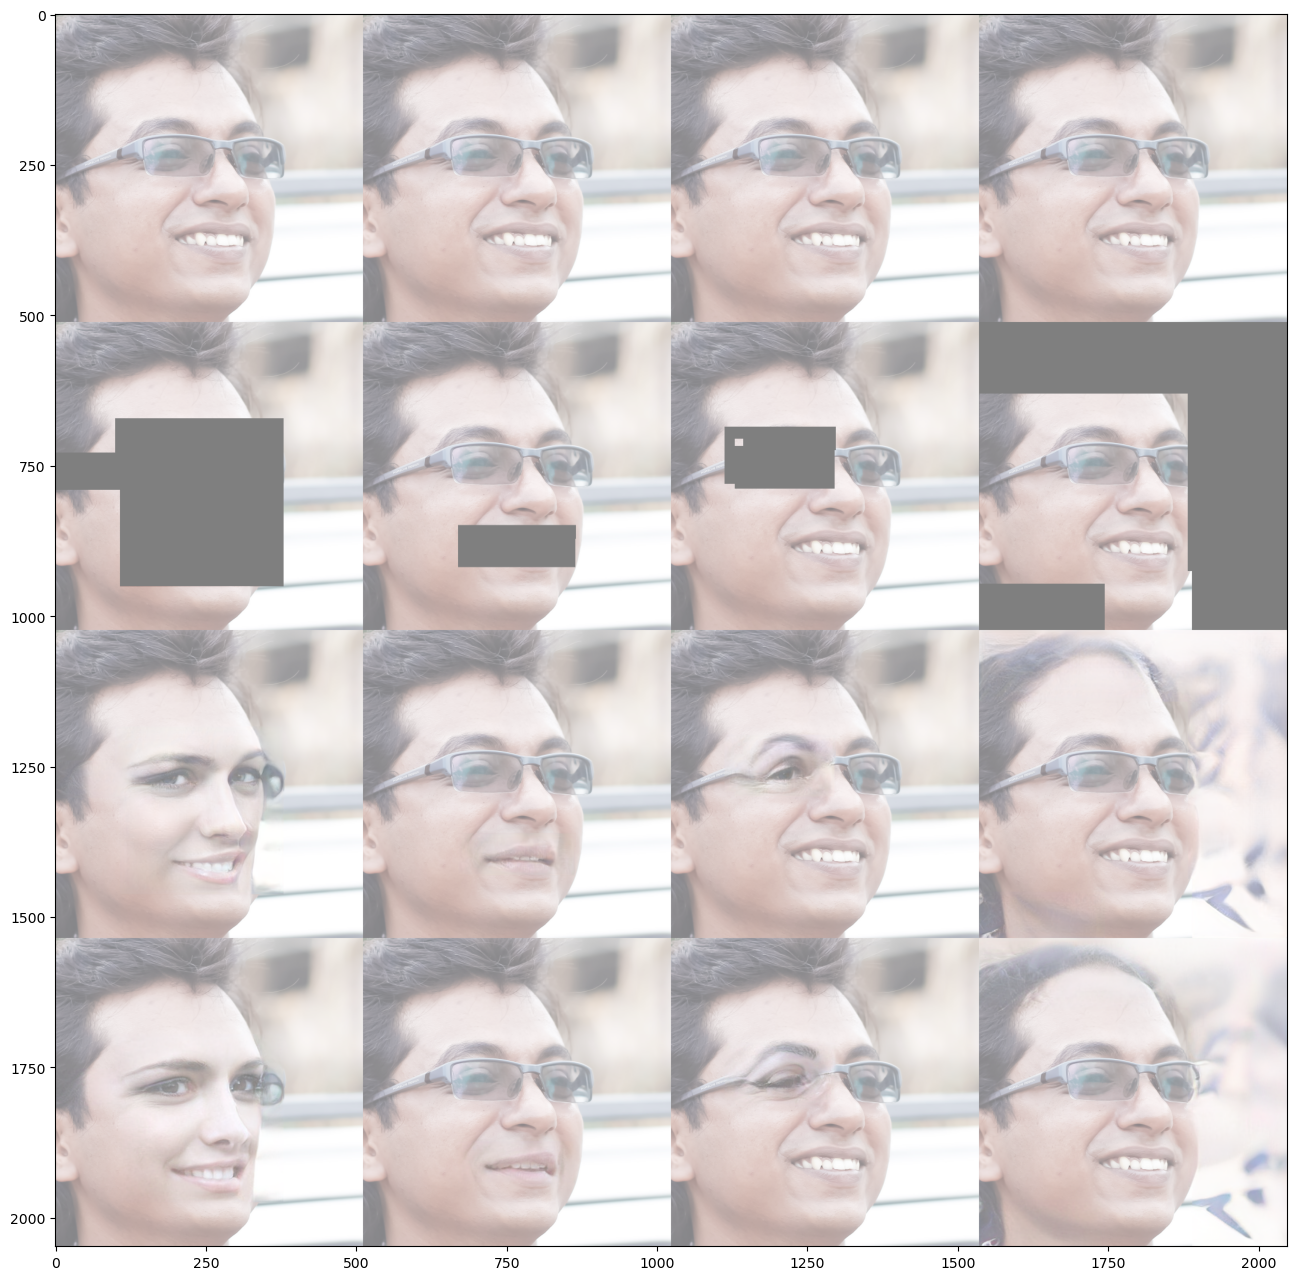

In [28]:
IMG_PATH = '/root/MAT/test_sets/CelebA-HQ/'
full_imgs = []

for i in range(4):
    full_imgs.append(mpimg.imread(IMG_PATH + 'images2/' + str(i) + '.png')[..., :-1])
for i in range(4):
    img = mpimg.imread(IMG_PATH + 'images2/' + str(i) + '.png')[..., :-1]
    mask = mpimg.imread(IMG_PATH + 'masks2/' + str(i) + '.png')
    if mask.shape == (512, 512, 4):
        mask = mask[..., :-1]
    full_imgs.append(img * mask)
for i in range(4):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples2_stg1/' + str(i) + '.png'))
for i in range(4):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples2/' + str(i) + '.png'))

plot_images(np.array(full_imgs), 'rectangle', (4, 4))

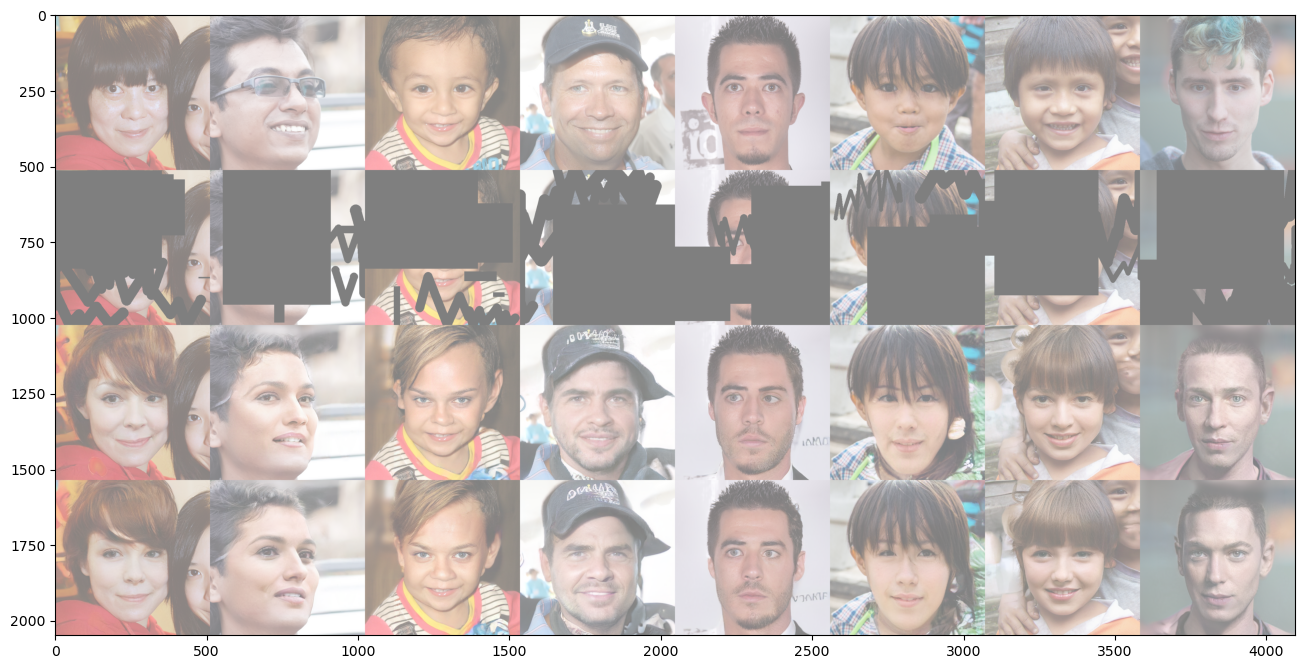

In [7]:
IMG_PATH = '/root/MAT/test_sets/CelebA-HQ/'
full_imgs = []

for i in range(8, 16):
    full_imgs.append(mpimg.imread(IMG_PATH + 'images3/' + str(i) + '.png')[..., :-1])
for i in range(8, 16):
    img = mpimg.imread(IMG_PATH + 'images3/' + str(i) + '.png')[..., :-1]
    mask = mpimg.imread(IMG_PATH + 'masks3/' + str(i) + '.png')[..., :-1]
    full_imgs.append(img * mask)
for i in range(8, 16):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples3_stg1/' + str(i) + '.png'))
for i in range(8, 16):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples3/' + str(i) + '.png'))

plot_images(np.array(full_imgs), 'rectangle', (4, 8))

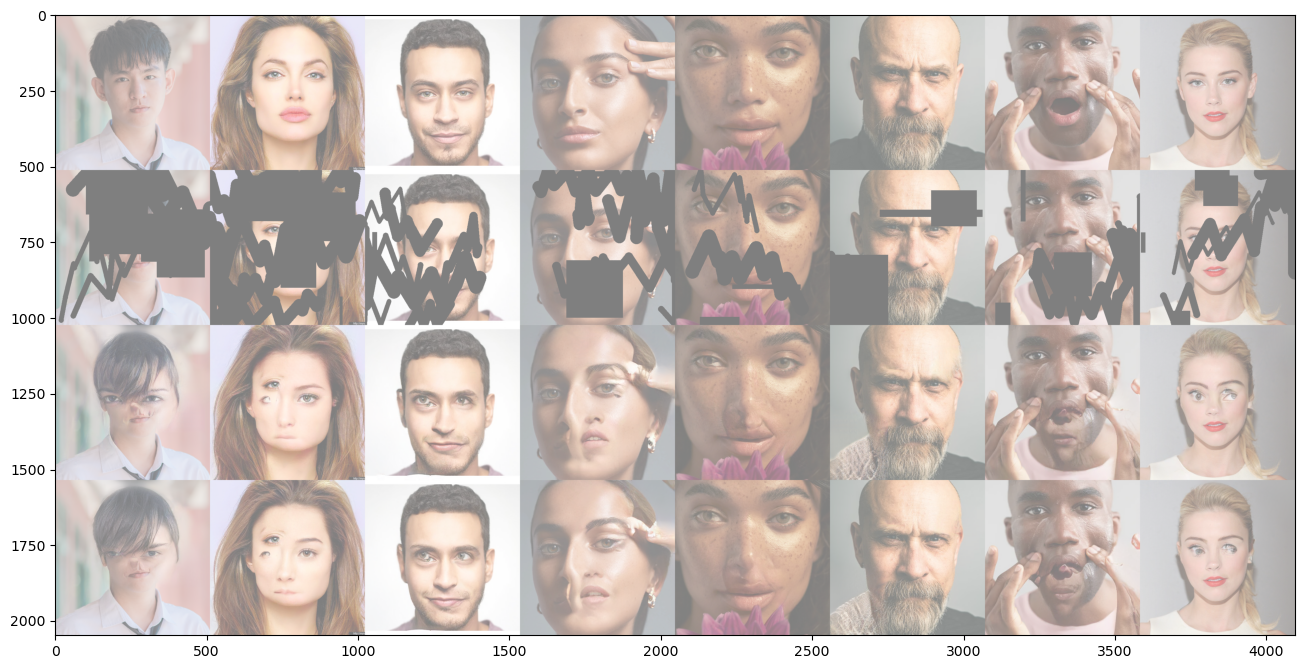

In [70]:
IMG_PATH = '/root/MAT/test_sets/CelebA-HQ/'
full_imgs = []

for i in range(8):
    full_imgs.append(mpimg.imread(IMG_PATH + 'images4/' + str(i) + '.jpg') / 255)
for i in range(8):
    img = mpimg.imread(IMG_PATH + 'images4/' + str(i) + '.jpg') / 255
    mask = mpimg.imread(IMG_PATH + 'masks4/' + str(i) + '.png')[..., :-1]
    full_imgs.append(img * mask)
for i in range(8):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples4_stg1/' + str(i) + '.png'))
for i in range(8):
    full_imgs.append(mpimg.imread(IMG_PATH + 'samples4/' + str(i) + '.png'))

plot_images(np.array(full_imgs), 'rectangle', (4, 8))